### Overview:


Executive Summary:

Our group used scraping tools and machine learning to analyze the top results for the ‘supplement’ search term on Amazon and attempt to determine trends in the success of specific products based on various indicators. We classified success based on our estimation of the daily revenue of a supplement, which took into account price, number of reviews, and time on the market. We ultimately analyzed our various regression approaches by determining the r squared value for each of them.

<img src="https://drive.google.com/uc?export=view&id=1FysmtSHdbPB-n7hk7Hw6mMkTvooJQykB" width=600px>

Introduction:
Success as an ecommerce business is highly dependent on choosing the correct product to sell. This decision is influenced by both supply and demand factors, but other qualities can affect the success of any given product in the marketplace. Armed with accurate information about the factors that affect product success with statistical significance, ecommerce sellers can make more informed and profitable decisions when starting or expanding their businesses.

Ethical considerations:

Data collection:
Out scraping functions only collected data that was publicly available about each Amazon listing. Additionally, both of our ‘getProductInfo’ and ‘extractMultiplePages’ functions have a wait time of .5 seconds after scraping information from a product to lower the impact that our functions have on the Amazon server.

Side effects of algorithm:
If our regression algorithm correctly predicts successful product metrics, it might lead to many sellers focusing on only specific supplement types and ignoring other types that many customers require for health reasons. Also, the algorithm views review count as an important indicator of a “successful” product, so sellers might try to keep knowledge of success hidden by deleting or reporting reviews to artificially suppress the review count. Finally, the algorithm currently only accounts for “hasTurmeric” and “hasMagnesium” as important ingredient indicators based on our analysis of the current market, so if a new type of ingredient becomes important that information would remain hidden from sellers unless the algorithm was rerun with a new ingredient analysis.

Data description:

Each of our data rows represented a product listing from the amazon search ‘supplement’. We only included listings that had titles, descriptions, prices, reviews, publishing dates and ingredient lists. Also, we ignored listings that were less than a year old because there appeared to be issues with certain supplements having publishing dates that updated daily.

<img src="https://drive.google.com/uc?export=view&id=13HnUFkzL5BlKx9ptdDfTTsUkshJH_2rE" width=600px>


### Pipeline Overview:
##### Extract:
- `extractAmazonSinglePage(html)`
  - Extracts information from a single page of Amazon products.
- `extractMultiplePages(numPages, searchTerm = 'supplements', saveToCSV = True)`
  - Extracts the given number of pages of product listings for the given search term.
- `getProductInfo(product_list)`
  - Adds a "productDescription" property to each entry in a list of product dictionaries (generated by our extraction functions)

##### Transform:
- `transform_data(item_list)`
  - Cleans the product data for each product
  - Includes information about the title,	productPageLink,	rating,	numReviews,	price,	productDescription,	firstPublished,	ingredients,	timePublished,	salesRevenue,	ingredientLength for each product

##### Load:
- `load_data(transformed_data)`
  - Loads the trand data into a DataFrame that we can then use for our analysis



### Pipeline:


In [1]:
# NOTE: this will have to be re-generated from time to time, just like what we 
# did with the Spotify API. See more https://sapiezynski.com/ds3000/adv_scraping.html
# I made a new Amazon account that we can use for testing (see link above):
# Email: 4tfp8w2az6@just4fun.me
# PW: %CfMu:wAB;g%j:2
curl_str = '''
curl 'https://www.amazon.com/gp/yourstore/home?ie=UTF8&action=sign-out&path=%2Fgp%2Fyourstore%2Fhome&ref_=nav_AccountFlyout_signout&signIn=1&useRedirectOnSuccess=1&captcha_verified=1&claim_type=EmailAddress&new_account=1' \
  -H 'Connection: keep-alive' \
  -H 'Pragma: no-cache' \
  -H 'Cache-Control: no-cache' \
  -H 'rtt: 50' \
  -H 'downlink: 10' \
  -H 'ect: 4g' \
  -H 'sec-ch-ua: "Chromium";v="88", "Google Chrome";v="88", ";Not A Brand";v="99"' \
  -H 'sec-ch-ua-mobile: ?0' \
  -H 'Upgrade-Insecure-Requests: 1' \
  -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36' \
  -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
  -H 'Sec-Fetch-Site: same-origin' \
  -H 'Sec-Fetch-Mode: navigate' \
  -H 'Sec-Fetch-User: ?1' \
  -H 'Sec-Fetch-Dest: document' \
  -H 'Referer: https://www.amazon.com/ap/cvf/verify' \
  -H 'Accept-Language: en-US,en;q=0.9' \
  -H 'Cookie: ubid-main=130-3845902-7266718; aws-priv=eyJ2IjoxLCJldSI6MCwic3QiOjB9; aws-target-static-id=1561557622494-202227; aws-target-data=%7B%22support%22%3A%221%22%7D; s_fid=42B6408AA297E855-1F8792ED77C01DC6; regStatus=pre-register; amznacsleftnav-8b1cbb0f-3455-4731-bd98-3e8937ea257b=1; p2dPopoverID_all_A1ZEXXTH1KW451=1582169745.725; p2dPopoverID_default_A1ZEXXTH1KW451=1582169745.725; ubid-tacbus=130-0011109-8446066; aws-target-visitor-id=1561557622499-943422.34_0; s_vn=1624999130326%26vn%3D2; skin=noskin; s_cc=true; s_nr=1608582119165-New; s_vnum=1992134767551%26vn%3D11; s_dslv=1608582119168; s_sq=%5B%5BB%5D%5D; s_ppv=100; ubid-acbus=135-3771825-2502117; csd-key=eyJ3YXNtVGVzdGVkIjp0cnVlLCJ3YXNtQ29tcGF0aWJsZSI6dHJ1ZSwid2ViQ3J5cHRvVGVzdGVkIjpmYWxzZSwidiI6MSwia2lkIjoiZDlkZmM0Iiwia2V5IjoiTVBlQzc2Rm5JYk9JL3pBSGxjK20zZWZwR0VzRmVURjE2cDh0UVZxbHBueWR5UHgvL2doNlhhR0NnNmVEVWhXR1NhMUdaSThPcUJ6NXIvQWQ4Z0ZiU29YRWExSkRJL1J5SkxPS3oyMVFJTWw0UzRtN0dia1k1VDVEQ2M5cjVZYXluS0RkYm5Rekc4SWFiejdmc2hFcitHZGRvYkVBVmlDZnlqMkxVMWlKMmJpbjVzbHNKWnNLdW5Ra2J2K0h4Ym1icEhRYmtQQVV6M3lnOFhZZnU1WnI2dkkyaWU4aTVLNTZseUdOSzRDeUJUdEZtSjJZWnMzQ01pYnQ2Vk40WWtscnFzbFg3Ukx3MENiQ1FQZTdTdjU2Yy9UK0U5M0F2WFlTendjWXRNVGkxZVYyY0JCMUxDSVpGMWFjZmtUaHVoMmhWTm9taTJuYUN3eE5QdmdjL2FzRDJBPT0ifQ==; session-id-apay=140-2334574-1560726; session-id=133-5731227-6517866; session-token=i6Hhl3tIhwie+/qrdNcZ7luxswa4VxGmpic5hLR163KmjPn/dLXf2O+B1oOvFpy/0S7kSx7FMyk7ynXNHQ22oOlrsfcz/hYzIe4wFsl4ancHdMslnxSuiidVww0GGye2lDs33/BTVwzUBYTTnAMFk+f5XhsnFKdkNhsgLqysgZJjoq/IMjAdjOxQNpOeW730Vn/GA6KCFYmJ3/+dihch+HMe2+R1uYywHxh+TUj06mMSbdO28QvgmnmaPf2eLwkgnI6GANmeZ1JGZd/MV3I30eMTRhcBjIeo; x-main="G49ptNw1gDPsw1kmft2AujV6n0FHkiA@qVt13rtogI@KTAOEy4X176Qf87MYYKnb"; at-main=Atza|IwEBIDAGgPS54_7nqmrhO1ytmnVUulETKWKiRSXZpUTFxilAUhJFZUCy_VGQqRjURrfGkcUFIBqEaz4_TvESvsRfakonSZcg51KMs34q-hzJZLfR6q2YbfatjVhFwqEucJdyIKu8FgQTdsCX9hBoerrd2r63HT_fIjlv9qd2ttgGa0lOli4bGsXtDTpU5Hq8mx_qd2msVdkemA8BNFVjtF2XDUjz; sess-at-main="p4sx+SpELmixq3JGi2qHNh0UJXvCLRPp2JNVoZ7FZKk="; sst-main=Sst1|PQGkUi7ULFnxS6bq06YTG-2RDh1-vVR_1vglnZMcZCA0RMTHxZDOINWQ-j79bXLwF-7aasyUtRsqi7lQoZXsZoRUkhyR7U0i0y7SVBU3oMsLrL1XsikpjpnIo_thoel5wRuERsCgmHqO0Ift_Ezb0QuwmlmagJbsss3CVs9eJklAOLAC_ju926Ks9bDg165gqmvsimzXqRgGK2fvYB2iPSekZMTfMt65vS_E0Zizlux5V0CPBcHwleR-ygP3vPnc1YP4E11GFZqhuwrKuAz9Cm9VNbYvljzAJjHeY3iNfnXNwWUBe8oj9g9V_mKzLWyZvhg4f7fwS3KR5JuIFbqeu0WJp1ZLZBmM5HMVC6LSInzkfrR4YXH9_Bfp8gOUybMoC_zdkoKN2ubxJozxKoSSGsbxqw; lc-main=en_US; session-id-time=2082787201l; i18n-prefs=USD; csm-hit=tb:XNTDWR8MNFB3V43CPKZM+s-E3XDJX7R18J0DXP8PRWB|1615943441597&adb:adblk_yes&t:1615943441597' \
  --compressed
'''

In [2]:
import scrapetools
import json
uncurled = scrapetools.uncurl(curl_str)

In [3]:
print(json.dumps(uncurled, indent=2))

{
  "base_url": "https://www.amazon.com/gp/yourstore/home",
  "params": {
    "ie": "UTF8",
    "action": "sign-out",
    "path": "/gp/yourstore/home",
    "ref_": "nav_AccountFlyout_signout",
    "signIn": "1",
    "useRedirectOnSuccess": "1",
    "captcha_verified": "1",
    "claim_type": "EmailAddress",
    "new_account": "1"
  },
  "headers": {
    "Connection": "keep-alive",
    "Pragma": "no-cache",
    "Cache-Control": "no-cache",
    "rtt": "50",
    "downlink": "10",
    "ect": "4g",
    "sec-ch-ua": "\"Chromium\";v=\"88\", \"Google Chrome\";v=\"88\", \";Not A Brand\";v=\"99\"",
    "sec-ch-ua-mobile": "?0",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "Sec-Fetch-Site": "same-origin",
    

In [4]:
response = scrapetools.request(uncurled, 'https://www.amazon.com/s?k=supplements&page=1')

In [5]:
import requests
from bs4 import BeautifulSoup

def extractAmazonSinglePage(html):
    """
    Extracts information from a single page of Amazon products. This information
    includes the following properties: 
      - hasSubscription: if you can create an Amazon subscription with this product
      - numReviews: the number of reviews for this product
      - price: the price of this product
      - pricePerCount: the price per count of this product
      - productPageLink: the link to this product's full product page
      - rating: the number of stars this product has. Can be fractional, i.e. 4.3
      - title: the full title of this product

    Scraping Amazon is challenging because Amazon does not appear to use IDs in
    their HTML elements. Targeting specific elements can still be done by searching
    for HTML elements with specific attributes, but narrowing down the correct elements
    often requires specifying an nth-child of some element. As a result, finding information
    is not always possible, since we do not have a full list of what can be contained
    in an Amazon listing. In such cases, we set properties to None.

    NOTE: if code breaks, try replacing cookie above as described on https://sapiezynski.com/ds3000/adv_scraping.html

    Args:
        html (str): the HTML of the Amazon page we want to get information from.

    Returns:
        product_info (list[dict]): a list of dictionaries where each dictionary has the properties listed above.
    """
    # Initialize BeautifulSouop for scraping
    soup = BeautifulSoup(html)

    # All products have a data-asin attribute
    products = soup.findAll(lambda tag: 'data-asin' in tag.attrs)
    
    # list of dictionaries that will contain the properties listed above for each product
    product_info = []
    for listing in products:
        # will be a single entry in product_info
        info = {}

        # Get the heading of this product, which will give us its title and link
        # to its full product page
        heading = listing.h2

        # There are some amazon listings that are ad stubs that do not contain
        # the necessary information. These stubs will be ignored here.
        productIsNotStub = heading != None and heading.a != None
        if productIsNotStub:
            info['title'] = heading.text

            # Link is only partial link, so this formats it correctly
            info['productPageLink'] = f"https://www.amazon.com/{heading.a.attrs['href']}"

            # Get rating and number of reviews if it exists. Otherwise, set both
            # to None.
            try:
              ratingsAndReviews = listing.find('span', {'data-component-type': 's-product-image'}).parent.findAll('div', recursive=False)[2]
              spans = ratingsAndReviews.div.findAll('span', recursive=False)
              info['rating'] = spans[0].attrs['aria-label']
              info['numReviews'] = spans[1].attrs['aria-label']
            except:
              info['rating'] = None
              info['numReviews'] = None

            # Get price if possible. Otherwise, set to None.
            try:
              info['price'] = listing.find('span', {'data-component-type': 's-product-image'}).parent.findAll('div', recursive=False)[3].find(class_='a-price').find(class_='a-offscreen').text
            except:
              info['price'] = None

            # COLLECT PRICE PER COUNT
            pricePerCount = listing.find('span', {'data-component-type': 's-product-image'}).parent.findAll('div', recursive=False)
            # if pricePerCount returns None, then calling .text on that would result in an error
            # I put this in a try-except for just in case pricePerCount is None which means the HTML didn't exist
            try:
              pricePerCount = pricePerCount[3].find('span', class_='a-size-base')
              info['pricePerCount'] = pricePerCount.text
            except:
              info['pricePerCount'] = None

            # COLLECT SUBSCRIPTION BOOLEAN
            subscribeInfo = listing.find('span', {'data-component-type': 's-product-image'}).parent.findAll('div', recursive=False)
            try:
              # If subscribeInfo cannot be found, then this will go into the except branch
              subscribeInfo = subscribeInfo[3].findAll('div', recursive=False)
              subscribeText = subscribeInfo[1].span.text if len(subscribeInfo) >= 2 else None

              # Make sure we've found a subscription div, and if so, set the subscription boolean to true
              info['hasSubscription'] = False if subscribeText == None else 'Subscribe & Save' in subscribeText
            except:
              info['hasSubscription'] = False

            # Add info to product_info
            product_info.append(info)

    return product_info

#extractAmazonSinglePage(response.text)

In [6]:
import time
import pandas as pd

def extractMultiplePages(numPages, searchTerm = 'supplements', saveToCSV = True):
    """
    Extracts the given number of pages of product listings for the given search term.

    Args:
        numPages (int): the number of pages to scrape
        searchTerm (str): the search term to use for scraping. Defaults to 'supplements'.
        saveToCSV (boolean): whether we should save this data to a CSV. Defaults to True.

    Returns:
        out (list[dict]): a list of dictionaries describing products where each 
        dictionary has the properties listed in the function extractSinglePage
    """
    # Request each page, scrape it, add it to an aggregated list
    multiplePageProductInfo = []
    for i in range(numPages):
        productPageHTML = scrapetools.request(uncurled, f'https://www.amazon.com/s?k={searchTerm}&page={i}').text
        productsInfo = extractAmazonSinglePage(productPageHTML)
        multiplePageProductInfo.extend(productsInfo)

        # wait a second before scraping again
        time.sleep(1)

    # option to save to csv
    if saveToCSV:
        pd.DataFrame(multiplePageProductInfo).to_csv('amazon_products.csv')
    
    return multiplePageProductInfo

# sanity test to make sure we're getting more results when we scrape more pages
assert len(extractMultiplePages(2)) > len(extractMultiplePages(1))

# for the demo we are only processing 2 pages due to the time it takes to process the full ten pages
# we have already saved a csv of the full ten pages, which we load further down
#tenProductPages = extractMultiplePages(10)
#tenProductPages

In [7]:
import time

def getProductInfo(product_list):
    """
    Looks into each product's full page in a list of products, then adds a 
    productDescription, firstPublished, and ingredients property to each 
    entry in the list of product dictionaries (generated by our extraction 
    functions). Note that this function waits .5 seconds before each new request,
    which means that for 100 products, it would take ~50 seconds.

    Args:
        product_list (list[dict]): a list of dictionaries, where each has the
          properties specified in the extraction functions

    Returns:
        with_info (list[dict]): the given list of dictionaries, now with
          information from their product pages.
    """
    with_info = []

    # Loop through all products and add a product description to each product
    for product in product_list:
        copied = product.copy()

        # Make web request, find the description text and ingredients.
        productPageHTML = scrapetools.request(uncurled, f"{copied['productPageLink']}").text
        soup = BeautifulSoup(productPageHTML)
        description = soup.find('div', {'data-feature-name': 'featurebullets'})
        head_info = soup.find('table', {'class': 'a-normal a-spacing-micro'})
        details = soup.find('div', {'data-feature-name': 'detailBullets'})

        # Ensure the description exists
        if description != None:
          description = description.text
          copied['productDescription'] = description

        # extract the date of listing publication from any product that contains that information
        if details != None:
          for list_item in details.findAll('li'):
            if list_item.text.strip()[:6] == 'Date F':
              copied['firstPublished'] = list_item.findAll('span')[2].text.strip()

        # extract each unique word from the product's ingredient list if available
        if head_info != None:
          ingredients = []
          head_info_list = head_info.findAll('tr', class_='a-spacing-small')
          for element in head_info_list:
            if element.find('span', class_='a-size-base a-text-bold').text.strip() == 'Ingredients':
              ingredient_info = element.findAll('span')
              for phrase in ingredient_info[1].text.strip().split(', '):
                for word in phrase.split(' '):
                 if (word.lower() not in ingredients):
                   word = word.replace('.','')
                   word = word.replace('(','')
                   word = word.replace(')','')
                   ingredients.append(word.lower())
          copied['ingredients'] = ingredients

        # time out the scraping for half a second
        time.sleep(.5)

        # append the new product info to the product info already extracted before
        with_info.append(copied)

    return with_info

# for the demo we are only processing 20 listings due to the time it takes to process the full 400+ listings
# we have already saved a csv of the full product list, which we load further down
#productsWithInfo = getProductInfo(tenProductPages)

In [8]:
import copy
from datetime import datetime
def transform_data(item_list):
  """
  Transform data columns into the right format, add new relevant columns and filter listings
  Args: 
    item_list (list): list of products with unfinished data


  Returns:
    new_list (list): list of products with finished and filtered data

  """
  # create a copy of the original list to edit
  item_list_copy = item_list.copy()
  new_list = []

  for idx, item in enumerate(item_list_copy):

    # we are only working with listings that have more than 8 columns due to passing the getProductInfo function
    relevant_keys = ['price','numReviews','rating','firstPublished','ingredients','productDescription']
    full_product = True
    for key in relevant_keys:
      # Ensure price is not None
      if key not in item.keys() or item['price'] == None:
        full_product = False
    if full_product:

      # set price, rating and number of reviews to floats
      item['price'] = float(str(item['price']).replace('$',''))

      item['numReviews'] = float(str(item['numReviews']).replace(',',''))

      item['rating'] = float(str(item['rating'])[:3])

      # add a column for the number of days since the product wss published on Amazon
      item['timePublished'] = float((datetime.now() - datetime.strptime(item['firstPublished'], '%B %d, %Y')).days)

      # calculate an estimated daily sales volume of the product, assuming:
      # - 5% of customers leave reviews
      # - profit margin is 30% on each item
      item['salesRevenue'] = (item['numReviews'] / 0.05) * item['price'] * 0.3 / item['timePublished']

      item['salesCount'] = (item['numReviews'] / 0.05 / item['timePublished'])

      item['rank'] = idx
      
      # create a row for the number of words in the ingredients list
      item['ingredientLength'] = (len(item['ingredients']))
      
      # remove listings that are under a year old (due to low level of data) and products with no ingredients
      if (item['timePublished'] > 365) and (len(item['ingredients']) > 0):
        new_list.append(item)

      # create a row for the length of the item's description list
      item['descriptionLength'] = (len(item['productDescription'].replace('\n\n\n', ' ').split(' ')))

      # Clean pricePerCount to be a single number, instead of a string.
      # Fill items that are None to 0.0, set other items to their numerical price per count
      p = item['pricePerCount']
      if p == None or item['price'] == None:
        item['pricePerCount'] = 0.0
      else:
        # Try-catch because some listings are already floats
        try:
          num_p = p[p.index('$') + 1 : p.index('/')]
          item['pricePerCount'] = float(num_p)
        except:
          pass
      
  return new_list

#transformedProducts = transform_data(productsWithInfo)
#transformedProducts

In [9]:
import pandas as pd

def load_data(transformed_data):
  """""
  load the data into a dataframe

  Args:
    transformed_data (list): data that is ready to be loaded

  Returns:
    df (dataframe): dataframe of transformed data
  """""
  df = pd.DataFrame(transform_data(transformed_data))
  return df

In [10]:
# this is the code that we would run to save the dataframe to a new csv if we were running every function
#amazon_dataframe.to_csv('amazon_product_info')

In the cell below import a csv file of previously extracted data for demonstration purposes.


In [11]:
amazon_df = pd.read_csv('transformed_amazon_products.csv')
amazon_df.drop('Unnamed: 0', axis=1,inplace=True)
amazon_df['hasSubscription'] = amazon_df['hasSubscription'].fillna(0)
amazon_df = pd.DataFrame(amazon_df)
amazon_df

,title,productPageLink,rating,numReviews,price,pricePerCount,hasSubscription,productDescription,firstPublished,ingredients,timePublished,salesRevenue,salesCount,rank,ingredientLength,descriptionLength
0,\n\nTurmeric Curcumin with BioPerine 1500mg - ...,https://www.amazon.com//Turmeric-Bioperine-Ava...,4.6,57207,18.79,0.21,1.0,\n\n\n\nAbout this item\n\n\n\nHigh potency tu...,"March 23, 2016","['turmeric', 'curcumin', '1500mg', '3', 'capsu...",1851,3484.342075,618.119935,4,25,217
1,\n\nTurmeric Curcumin with BioPerine 95% Curcu...,https://www.amazon.com//Curcuminoids-Absorptio...,4.6,43045,14.82,0.12,1.0,\n\n\n\nAbout this item\n\n\n\nTurmeric Curcum...,"June 28, 2017","['turmeric', 'curcumin', 'curcuma', 'longaroot...",1389,2755.623758,619.798416,5,16,205
2,"\n\nUMZU: Redwood, Nitric Oxide Booster Capsul...",https://www.amazon.com//UMZU-Capsules-N-Supple...,4.3,4755,49.95,0.00,1.0,\n\n\n\nAbout this item\n\n\n\nNATURAL: Redwoo...,"January 2, 2020","['vitamin', 'c', 'as', 'ascorbic', 'acid', 'ga...",471,3025.633758,201.910828,6,35,97
3,"\n\nGenius Mushroom – Lions Mane, Cordyceps an...",https://www.amazon.com//Genius-Mushroom-Cordyc...,4.5,19559,21.95,0.24,1.0,\n\n\n\nAbout this item\n\n\n\nNURTURE YOUR MI...,"January 3, 2018","['organic', 'cordeyceps', 'militaris', 'and', ...",1200,2146.600250,325.983333,7,15,180
4,"\n\nGenius Mushroom – Lions Mane, Cordyceps an...",https://www.amazon.com//Genius-Mushroom-Cordyc...,4.5,19559,21.95,0.24,1.0,\n\n\n\nAbout this item\n\n\n\nNURTURE YOUR MI...,"January 3, 2018","['organic', 'cordeyceps', 'militaris', 'and', ...",1200,2146.600250,325.983333,8,15,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,\n\nTurmeric Curcumin with BioPerine 1500mg - ...,https://www.amazon.com//Turmeric-Curcumin-BioP...,4.6,1702,21.95,0.12,1.0,\n\n\n\nAbout this item\n\n\n\nNutraChamps\n\n...,"January 30, 2017","['1500mg', 'turmeric', 'curcumin', '3', 'capsu...",1538,145.743433,22.132640,451,25,267
224,\n\nNeuro Support Supplement | 120 Capsules | ...,https://www.amazon.com//Supplement-Capsules-Ad...,4.3,28,15.99,0.13,1.0,\n\n\n\nAbout this item\n\n\n\nNEURO SUPPORT C...,"February 18, 2020","['bacopa', ""lion's"", 'mane', 'mushroom', 'l-ty...",424,6.335660,1.320755,452,25,69
225,\n\nSheer Strength Labs BCAA Capsules - Extra ...,https://www.amazon.com//Sheer-Strength-Labs-BC...,4.3,1650,15.97,0.18,1.0,\n\n\n\nAbout this item\n\n\n\nBUILD MUSCLE FA...,"May 22, 2014","['gelatin', 'capsule', 'magnesium', 'stearate'...",2522,62.689532,13.084853,455,6,218
226,\n\nPotassium Supplement 365 Tablets 1 Year Su...,https://www.amazon.com//Potassium-Chloride-99m...,4.7,226,19.97,0.05,1.0,\n\n\n\nAbout this item\n\n\n\n✓ EVERYDAY GREA...,"April 15, 2020","['potassium', 'chloride', 'cellulose', 'steari...",367,73.785613,12.316076,458,9,373


### Visualizations:

To begin, our team did a simple pairplot visualization of all the variables and their relationships.

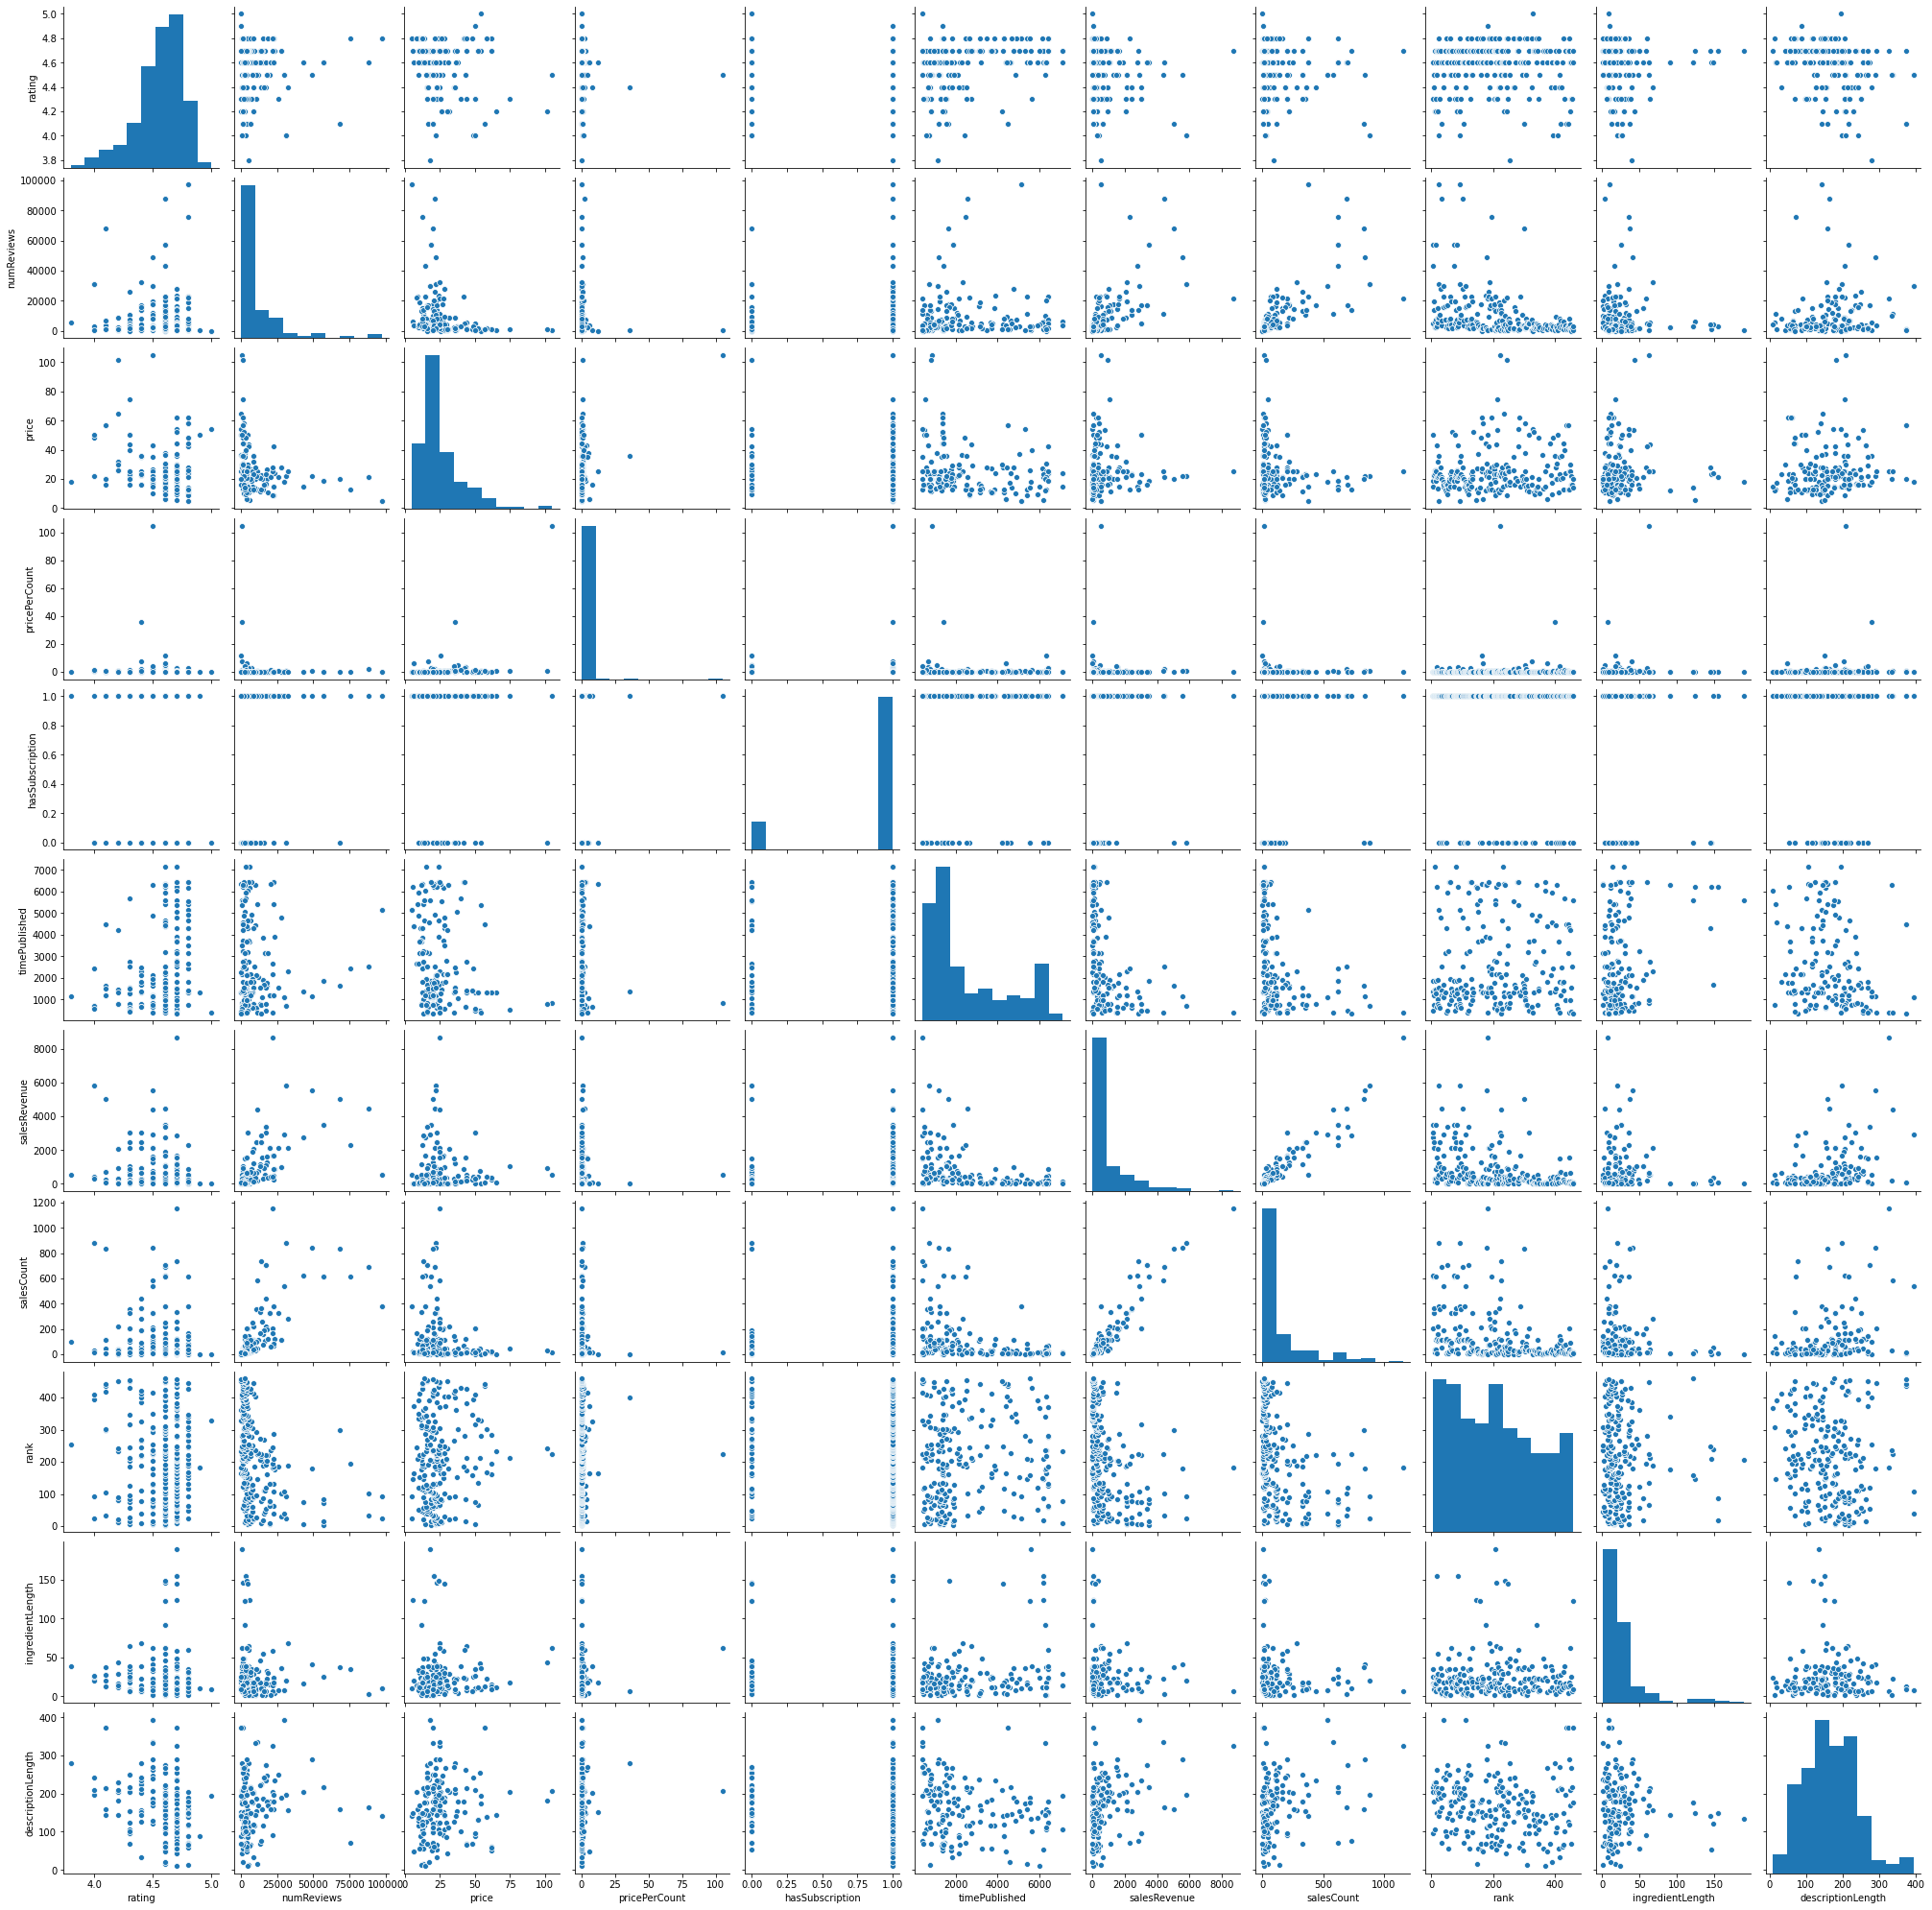

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(amazon_df)

We also created a function to analyze ingredient lists and return the most common ingredient words.

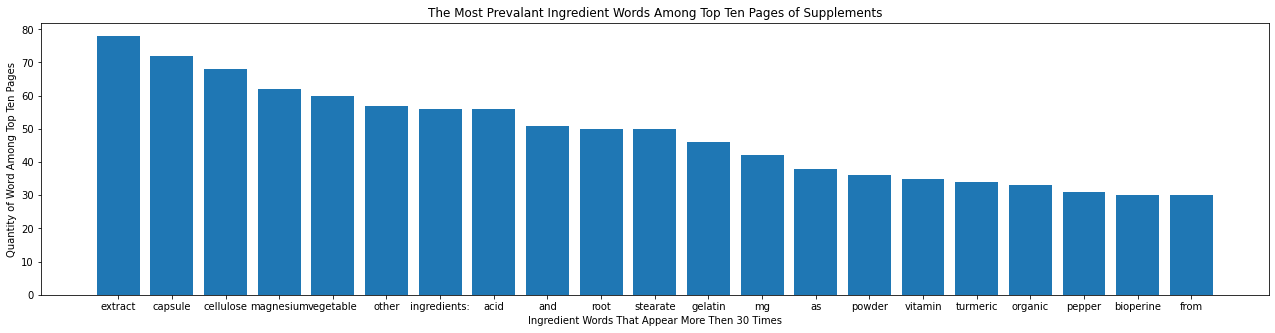

In [13]:
import matplotlib.pyplot as plt

def ingredient_compare(supplement_dataframe):
  """""
  Creates a dictionary of words from ingredient lists with the quantity that they are found among extracted products

  Args:
    supplement_dataframe (dataframe): dataframe of supplements with ingredients lists

  Returns:
    ingredients_all (dict): dictionary of all ingredient words with the amount of times they show up
  """""
  ingredients_all = {}

  # create a key for each ingredient word and a value for the number of times it shows up
  for idx, row in supplement_dataframe.iterrows():

    # turn the ingredients lists back into lists (they were imported as strings)
    row['ingredients'] = list(set(row['ingredients'].replace('[','').replace(']','').replace('\'','').split(', ')))
    for word in row['ingredients']:
      if (ingredients_all.get(word) is None):
        ingredients_all[word] = 0
      else:
        ingredients_all[word] += 1
  
  # filter the list to only include words that show up at least 30 times
  ingredients_all = dict(filter(lambda elem: elem[1] >= 30, ingredients_all.items()))

  return ingredients_all

ing = ingredient_compare(amazon_df)

# sort the list from greatest to smallest prevelancy
ing = {k: v for k, v in sorted(ing.items(), key=lambda item: item[1], reverse=True)}
x, y = zip(*ing.items()) 

# create bar plot and set title, labels, and size
plt.bar(x, y)
plt.title('The Most Prevalant Ingredient Words Among Top Ten Pages of Supplements')
plt.xlabel('Ingredient Words That Appear More Then 30 Times')
plt.ylabel('Quantity of Word Among Top Ten Pages')
plt.gcf().set_size_inches(22,5)

# note: some of these words are not ingredient words (such as 'ingredients:', 'from' and 'mg'). This will be cleaned up in later drafts
plt.show()

After combing through the top words among supplement ingredients, we only found three relevant ingredient words that occured in at least 30 listings: magnesium, turmeric and cellulose. Therefore, the presence or absesence of each of these words will be added as boolean columns.

In [14]:
import seaborn as sns
sns.set()
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylaningham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylaningham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def str_to_list(df):
  """Cleans up the ingredients for each product so that stop words

  Args:
    df (pd.DataFrame): the amazon product dataframe
  
  Returns:
    filtered (list): the list of list of filtered ingredients for each product
   """

  # initalize empty ingredients list 
  ingredients = []
  for idx, row in df.iterrows():
    # remove all punctuation marks for ingridents and adds it to the list
    ingredients.append(row['ingredients'].replace('[','').replace(']','').replace('\'','').replace(',', ''))

  # initialize the stop words in english
  stop_words = set(stopwords.words('english')) 
  # add common stop words in dataframe that are not already in stop_words
  stop = ['%', '-', ':', '``', 'flavor', 'natural', ';', '&', "''", 'organic', 'new']
  for s in stop:
    stop_words.add(s)
    
  # initialize the filtered list of ingredients
  filtered = []
  for ingr in ingredients:
    # filter about the ingredients so that stop words are removed
    word_tokens = word_tokenize(ingr) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered.append(filtered_sentence)

  return filtered

In [16]:
df_amazon = amazon_df
# set the ingr_list to the list of list of cleaned ingredients
ingr_list = str_to_list(df_amazon)

# create a dataframe for the ingredients list 
df = pd.DataFrame(ingr_list)
# transpose so that each column is a list
df = df.transpose()
# save dataframe to exce
df.to_excel("ingredients.xlsx")


def pop_ingr(ingr_list): 
  """Counts the products which have the popular ingredients and plots them
  
  Args:
    ingr_list (list): the list of list of ingredients 
  """

  # using the excel, manually go through ingredients list and found this common ingredients
  # some ingredients have multiple names which is why they are put into lists
  popular = [['vegetable', 'cellulose', 'veg', 'veggie'], ['turmeric', 'curcuma', 'curcumin', 'longa'], ['magnesium'],
          ['fruit'], ['rice'], ['pepper'], ['silica'], ['gelatin'],
          ['bovine'], ['root'], ['stearate'], ['vitamin']]
  # define the keys which are the ingredients names
  keys = ['cellulose', 'turmeric', 'magnesium', 'fruit', 
        'rice', 'pepper', 'silica', 'gelatin', 
        'bovine', 'root', 'stearate', 'vitamin']

  # initialize the ingredients count and list 
  ingr_count = {key: None for key in keys}
  count_list = []


  # for each ingredient which may have multiple names
  for p_list in popular:
    c = 0
    for p in p_list: 
      for l in ingr_list:
        # count each time the ingredient appears in a product
        count = l.count(p)
        c+= count
    # add the count to the count list 
    count_list.append(c)
    
  i = 0
  for k in ingr_count:
    # add the count of the ingredients into the dict
    ingr_count[k] = count_list[i]
    i += 1

  #sort the dict so that it is in order
  sorted_ingr = {k: v for k, v in sorted(ingr_count.items(), key=lambda item: item[1], reverse=True)}
  # zip the sorted list that the count corresponds to the ingredient
  x, y = zip(*sorted_ingr.items()) 

  # plots the graph 
  bars = plt.bar(x, y)
  # show the number above each bar
  for b in bars:
    plt.text(b.get_x() + b.get_width()/2., 1.05*b.get_height(), 
             b.get_height(), ha='center', va='bottom')
  plt.title('Popular Ingredients Count')
  plt.xlabel('Ingredients')
  plt.ylabel('Count')
  plt.gcf().set_size_inches(22,5)
  plt.show()



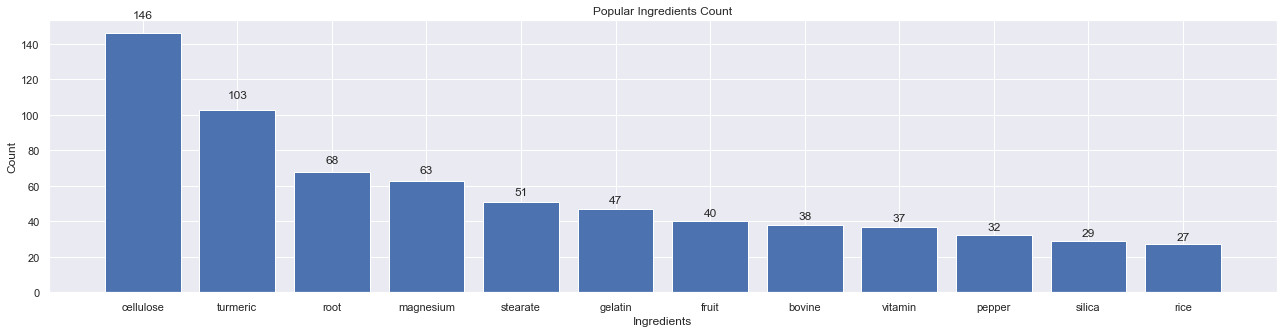

In [17]:
pop_ingr(ingr_list)

In [18]:
def bool_ingr_col(ingr_list, df):
  """Adds the boolean columns to the dataframe which indicates whether a product has a certain ingredient
    
  Args:
    ingr_list (list): the list of list of ingredients 
    df (pd.DataFrame): the amazon product dataframe

  Returns:
    df (pd.DataFrame): the amazon product dataframe with boolean columns for 3 ingredients 
   """

  # the ingredients to have a column
  ingrs = [['vegetable', 'cellulose', 'veg', 'veggie'],
           ['turmeric', 'curcuma', 'curcumin', 'longa'], 
           ['magnesium']]
        
  # initialize the list of columns for the dataframe
  hasIngr = []
  
  for each in ingrs:
    # initialize the list of booleans 
    ingrIn = []
    for l in ingr_list:
        count = 0
        # for each name of ingredient, if the ingredient list has any 
        # of the names count will increaase
        for i in each: 
            if i in l:
                count += 1
        # boolean of wether the list had any of the ingredient names
        ingrIn.append(count>0)
    # add the boolean list to the column list
    hasIngr.append(ingrIn)

  # add the columns to the dataframe
  df['hasCellulose'] = hasIngr[0]
  df['hasTurmeric'] = hasIngr[1]
  df['hasMagnesium'] = hasIngr[2]

  return df

The cell below shows the fully transformed dataset to be used on our machine learning algorithms after we've used visualizations to determine relevant ingredient keywords

In [19]:
df_amazon = bool_ingr_col(ingr_list, df_amazon)
df_amazon.head()

,title,productPageLink,rating,numReviews,price,pricePerCount,hasSubscription,productDescription,firstPublished,ingredients,timePublished,salesRevenue,salesCount,rank,ingredientLength,descriptionLength,hasCellulose,hasTurmeric,hasMagnesium
0,\n\nTurmeric Curcumin with BioPerine 1500mg - ...,https://www.amazon.com//Turmeric-Bioperine-Ava...,4.6,57207,18.79,0.21,1.0,\n\n\n\nAbout this item\n\n\n\nHigh potency tu...,"March 23, 2016","['turmeric', 'curcumin', '1500mg', '3', 'capsu...",1851,3484.342075,618.119935,4,25,217,True,True,False
1,\n\nTurmeric Curcumin with BioPerine 95% Curcu...,https://www.amazon.com//Curcuminoids-Absorptio...,4.6,43045,14.82,0.12,1.0,\n\n\n\nAbout this item\n\n\n\nTurmeric Curcum...,"June 28, 2017","['turmeric', 'curcumin', 'curcuma', 'longaroot...",1389,2755.623758,619.798416,5,16,205,True,True,False
2,"\n\nUMZU: Redwood, Nitric Oxide Booster Capsul...",https://www.amazon.com//UMZU-Capsules-N-Supple...,4.3,4755,49.95,0.00,1.0,\n\n\n\nAbout this item\n\n\n\nNATURAL: Redwoo...,"January 2, 2020","['vitamin', 'c', 'as', 'ascorbic', 'acid', 'ga...",471,3025.633758,201.910828,6,35,97,False,False,False
3,"\n\nGenius Mushroom – Lions Mane, Cordyceps an...",https://www.amazon.com//Genius-Mushroom-Cordyc...,4.5,19559,21.95,0.24,1.0,\n\n\n\nAbout this item\n\n\n\nNURTURE YOUR MI...,"January 3, 2018","['organic', 'cordeyceps', 'militaris', 'and', ...",1200,2146.600250,325.983333,7,15,180,False,False,False
4,"\n\nGenius Mushroom – Lions Mane, Cordyceps an...",https://www.amazon.com//Genius-Mushroom-Cordyc...,4.5,19559,21.95,0.24,1.0,\n\n\n\nAbout this item\n\n\n\nNURTURE YOUR MI...,"January 3, 2018","['organic', 'cordeyceps', 'militaris', 'and', ...",1200,2146.600250,325.983333,8,15,180,False,False,False


### Analysis Plan:

For our analysis we decided to run a variety of regression algorithms with cross-validated r squared values to determing if any data points could predict product info that is relevant to sellers (such as sales revenue, sales count and rank).

For each of the tests we determined the r squared value and printed out the equation for the algorithm.

In [20]:
def coef_to_poly_str(coef, x_label, y_label, include_zero=False):
    """ creates a str of polynomial corresponding to coef    

    Args:
        coef (np.array): coefficients of polynomial
        
    Returns:
        poly_str (str): str of polynomial
    """
    
    str_monomial_list = []
    for deg, coef in enumerate(coef):
        if coef == 0 and include_zero == False:
            continue
        str_monomial_list.append(f'{coef:+.1f} {x_label}^{deg:d}')
        
    # handle case of all zero coef
    if len(str_monomial_list):
        poly_str = ' '.join(str_monomial_list)
    else:
        poly_str = '0'
        
    return f'{y_label} = {poly_str} '

Run linear, exponential and polynomial regression on pricePerCount (price per capsule in the package) vs salesCount (estimated sales volume per day).

In [21]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

# initialize regression object
reg = LinearRegression()

# get target variable
x_feat_list = 'pricePerCount'
y_feat = 'salesCount'
x = df_amazon.loc[:, x_feat_list].values
x = x.reshape(-1,1)
y = df_amazon.loc[:, y_feat].values



# Linear Regression Model

# fit the data to a linear model
reg.fit(x, y)
# get the predicted y values
y_hat_lin = reg.predict(x)
# extract coefficients from linear model
a_0_pred = reg.intercept_
a_1_pred = reg.coef_[0]
lin_reg = f'salesCount = {a_0_pred: .2f} + {a_1_pred: .2f} pricePerCount'


# Exponential Regression Model

# fit the data to an exp model
reg.fit(x, np.log(y))
# get the predicted y values
y_hat_exp = np.exp(reg.predict(x))
# for graph
x_exp = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
y_exp = np.exp(reg.predict(x_exp))
# extract coefficients from exponential model
a_0_pred = reg.intercept_
a_1_pred = reg.coef_[0]
alpha0_pred = np.exp(a_0_pred)
exp_reg = f'salesCount = {alpha0_pred:.2f} e^({a_1_pred:.2f} pricePerCount)'



# Degree 2 Polynomial (Quadratic) Regression Model
reg = LinearRegression(fit_intercept=False)

# set the polynomial features to degree 2 and transform the x values
poly_feat = PolynomialFeatures(degree=2)
x_poly = poly_feat.fit_transform(x)
# fit the data to a polynomial model
reg.fit(x_poly, y)
# extract coefficients from polynomial model
y_pred_poly = reg.predict(x_poly)

x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1, 1)
x_fine_poly = poly_feat.fit_transform(x_fine)
# for graph
y_pred_fine = reg.predict(x_fine_poly)
y_pred_poly = reg.predict(x_poly)

# extract coefficients from polynomial model
coef_pred = [reg.intercept_] + list(reg.coef_[1:])
poly_reg = coef_to_poly_str(coef_pred, 'pricePerCount', 'salesCount')

print(lin_reg)
print(exp_reg)
print(poly_reg)

salesCount =  144.97 + -1.77 pricePerCount
salesCount = 53.02 e^(-0.02 pricePerCount)
salesCount = -7.7 pricePerCount^1 +0.1 pricePerCount^2 


The function below is used to determine the cross-validated r squared values from the equations above.

In [22]:
def cross_val_r2(x, y, model, n_splits=10):
    '''Returns the 10 fold cross validated r^2 value for the given regression model
    
    Args:
        x (array): input values 
        y (array): corresponding output values
        model (str): string describing the type of regression model
        n_splits (int): number of folds in the cross validation
    
    Returns:
        r2 (float): the cross validated r^2 value for the given regression model
    '''
    
    # initialize an empty array the same length as y
    y_pred = np.empty_like(y)
    
    # use the given number of splits in our cross validation
    kf = KFold(n_splits=n_splits)
    
    for train_idx, test_idx in kf.split(x):
        
        # set the train and test values
        x_train, y_train = x[train_idx], y[train_idx]
        x_test, y_test = x[test_idx], y[test_idx]
        
        # for linear regression, no modifications
        if model == 'linear':
            x_train_fit = x_train
            x_test_fit = x_test
            # initialize regression object
            reg = LinearRegression()
            
        # for exponential regression, take the log of the y train values 
        elif model == 'exponential':
            x_train_fit = x_train
            x_test_fit = x_test
            y_train = np.log(y_train)
            # initialize regression object
            reg = LinearRegression()
            
        # for polynomial regression, use degree 2 and fit transform the x train and x test values
        elif model == 'polynomial':
            poly_feat = PolynomialFeatures(degree=2)
            x_train_fit = poly_feat.fit_transform(x_train)
            x_test_fit = poly_feat.fit_transform(x_test)
            # initialize regression object differently since we have poly features
            reg = LinearRegression(fit_intercept=False)
        
        # fit the train values to the regression model 
        reg.fit(x_train_fit, y_train) 
        
        # get the predicted y scores based on the fit
        y_pred[test_idx] = reg.predict(x_test_fit)
    
    return r2_score(y, y_pred)

# create a list of classifiers
classifiers = ['linear', 'exponential', 'polynomial']

# initialize a list of r^2 values
r2_vals = []

for clf in classifiers:
    r2 = cross_val_r2(x, y, clf)
    r2_vals.append(r2)
    print(f'{clf} r^2: {r2}')

linear r^2: -0.0573062387979002
exponential r^2: -0.45765709735625615
polynomial r^2: -0.19296170911275268


In the cell below we graph the regressions from above. Notably, there is extreme pricePerCount outlier data that effects the regressions (and is the result of incorrectly labelled products), but even setting a more reasonable cutoff of less than $5 still led to negative r squared values for all three regressions. Therefore, we decided to leave the original data for full transparency and to show how correctly scraped data can still contain incorrect labels that need to be accounted for.

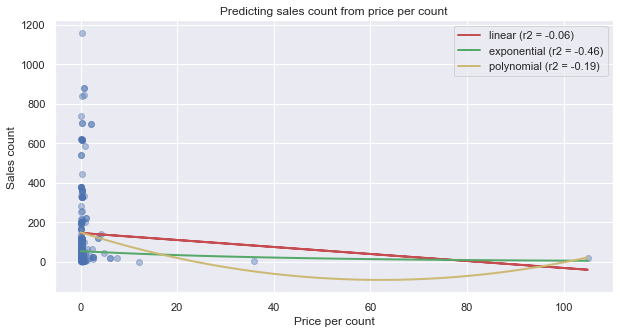

In [23]:
# plot the scatter of each 
plt.scatter(x, y, alpha=0.4)

# plot linear regression model
plt.plot(x, y_hat_lin, linewidth=2, color='r', label=f'linear (r2 = {r2_vals[0]:.2f})')

# plot exponential regression model 
plt.plot(x_exp, y_exp, linewidth=2, color='g', label=f'exponential (r2 = {r2_vals[1]: .2f})')

# plot polynomial regression model
plt.plot(x_fine, y_pred_fine, linewidth=2, color='y', label=f'polynomial (r2 = {r2_vals[2]: .2f})')

# add labels and a legend
plt.legend()
plt.title('Predicting sales count from price per count')
plt.xlabel('Price per count')
plt.ylabel('Sales count')

# make the figue size larger for easier readability
plt.gcf().set_size_inches(10, 5)

Run multi-variable linear regression on sales count. The variables we chose were all quantitative and unused in our salesCount calculation to make sure that they were truly independent. 



In [24]:
# initialize regression object
reg = LinearRegression()

# get target variable
x_feat_list = ['rating', 'pricePerCount', 'descriptionLength', 'hasMagnesium', 
               'hasCellulose', 'hasTurmeric', 'ingredientLength', 'hasSubscription']
y_feat = 'salesCount'
x = df_amazon.loc[:, x_feat_list].values
y = df_amazon.loc[:, y_feat].values
    
# fit regression
reg.fit(x, y)

# run test/train split on fitted regression
kf = KFold(n_splits=10)
y_hat = np.empty_like(y)
for train_idx, test_idx in kf.split(x):
    
    # set the train and test values
    x_train, y_train = x[train_idx], y[train_idx]
    x_test, y_test = x[test_idx], y[test_idx]

    reg.fit(x_train, y_train) 
        
    # get the predicted y scores based on the fit
    y_hat[test_idx] = reg.predict(x_test)

# print an equation will all coefficients and the intercept
equa_list = []
equa_list.append(f'{reg.intercept_: .2f} ')
for idx, feat in enumerate(x_feat_list):
  equa_list.append(f'{reg.coef_[idx]: .2f} {feat} ')

print(f'sales count ={equa_list[0]}{equa_list[1]}{equa_list[2]}+{equa_list[3]}+{equa_list[4]}+{equa_list[5]}+{equa_list[6]}{equa_list[7]}+{equa_list[8]}')

# store regression stats (dataframe prints nicely)
r2 = r2_score(y_true=y, y_pred=y_hat)

print(f'R^2={r2:.2f}')

sales count = 399.68 -99.05 rating -2.67 pricePerCount + 1.12 descriptionLength + 8.98 hasMagnesium + 103.61 hasCellulose + 78.44 hasTurmeric -1.48 ingredientLength + 8.22 hasSubscription 
R^2=0.05


Run multi-variable linear regression on sales revenue.

In [25]:
# initialize regression object
reg = LinearRegression()

# get target variable
x_feat_list = ['rating', 'pricePerCount', 'descriptionLength', 'hasMagnesium', 
               'hasCellulose', 'hasTurmeric', 'ingredientLength', 'hasSubscription']
y_feat = 'salesRevenue'
x = df_amazon.loc[:, x_feat_list].values
y = df_amazon.loc[:, y_feat].values
    
# fit regression
reg.fit(x, y)

# run test/train split on fitted regression
kf = KFold(n_splits=10)
y_hat = np.empty_like(y)
for train_idx, test_idx in kf.split(x):
    
    # set the train and test values
    x_train, y_train = x[train_idx], y[train_idx]
    x_test, y_test = x[test_idx], y[test_idx]

    reg.fit(x_train, y_train) 
        
    # get the predicted y scores based on the fit
    y_hat[test_idx] = reg.predict(x_test)

# print an equation will all coefficients and the intercept
equa_list = []
equa_list.append(f'{reg.intercept_: .2f} ')
for idx, feat in enumerate(x_feat_list):
    equa_list.append(f'{reg.coef_[idx]: .2f} {feat} ')

print(f'sales revenue ={equa_list[0]}{equa_list[1]}{equa_list[2]}+{equa_list[3]}+{equa_list[4]}+{equa_list[5]}+{equa_list[6]}{equa_list[7]}+{equa_list[8]}')

# store regression stats (dataframe prints nicely)
r2 = r2_score(y_true=y, y_pred=y_hat)

print(f'R^2={r2:.2f}')

sales revenue = 5426.86 -1237.85 rating -12.93 pricePerCount + 6.52 descriptionLength + 26.00 hasMagnesium + 378.22 hasCellulose + 284.43 hasTurmeric -6.28 ingredientLength + 109.99 hasSubscription 
R^2=0.01


Run multi-variable linear regression on rank.



In [26]:
# initialize regression object
reg = LinearRegression()

# get target variable
x_feat_list = ['rating', 'pricePerCount', 'descriptionLength', 'hasMagnesium', 
               'hasCellulose', 'hasTurmeric', 'ingredientLength', 'hasSubscription']
y_feat = 'rank'
x = df_amazon.loc[:, x_feat_list].values
y = df_amazon.loc[:, y_feat].values
    
# fit regression
reg.fit(x, y)

kf = KFold(n_splits=10)

for train_idx, test_idx in kf.split(x):
    
    # set the train and test values
    x_train, y_train = x[train_idx], y[train_idx]
    x_test, y_test = x[test_idx], y[test_idx]

    reg.fit(x_train, y_train) 
        
    # get the predicted y scores based on the fit
    y_hat[test_idx] = reg.predict(x_test)

# print an equation will all coefficients and the intercept
equa_list = []
equa_list.append(f'{reg.intercept_: .2f} ')
for idx, feat in enumerate(x_feat_list):
  equa_list.append(f'{reg.coef_[idx]: .2f} {feat} ')

print(f'rank ={equa_list[0]}{equa_list[1]}+{equa_list[2]}{equa_list[3]}{equa_list[4]}+{equa_list[5]}+{equa_list[6]}{equa_list[7]}{equa_list[8]}')

# store regression stats (dataframe prints nicely)
r2 = r2_score(y_true=y, y_pred=y_hat)

print(f'R^2={r2:.2f}')

rank = 298.79 -1.47 rating + 1.59 pricePerCount -0.47 descriptionLength -17.23 hasMagnesium + 6.49 hasCellulose + 2.60 hasTurmeric -0.07 ingredientLength -38.58 hasSubscription 
R^2=-0.44


Run linear regression of sales revenue on rank.

In [27]:
# initialize regression object
reg = LinearRegression()

# get target variable
x_feat_list = 'salesRevenue'
y_feat = 'rank'
x = df_amazon.loc[:, x_feat_list].values
x = x.reshape(-1,1)
y = df_amazon.loc[:, y_feat].values
    
# fit regression
reg.fit(x, y)

# run test/train split on fitted regression
kf = KFold(n_splits=10)
for train_idx, test_idx in kf.split(x):
    
    # set the train and test values
    x_train, y_train = x[train_idx], y[train_idx]
    x_test, y_test = x[test_idx], y[test_idx]

    reg.fit(x_train, y_train) 
        
    # get the predicted y scores based on the fit
    y_hat[test_idx] = reg.predict(x_test)

print(f'price = {reg.intercept_} + {reg.coef_[0]} salesRevenue')
    
# store regression stats (dataframe prints nicely)
r2 = r2_score(y_true=y, y_pred=y_hat)

print(f'R^2={r2:.2f}')

price = 208.53097327585618 + -0.028011374691675663 salesRevenue
R^2=-0.12


RUN LINEAR REGRESSION OF TIME PUBLISHED ON RANK

In [28]:
# initialize regression object
reg = LinearRegression()

# get target variable
x_feat_list = 'timePublished'
y_feat = 'rank'
x = df_amazon.loc[:, x_feat_list].values
x = x.reshape(-1,1)
y = df_amazon.loc[:, y_feat].values
    
# fit regression
reg.fit(x, y)

# run test/train split on fitted regression
kf = KFold(n_splits=10)
for train_idx, test_idx in kf.split(x):
    
    # set the train and test values
    x_train, y_train = x[train_idx], y[train_idx]
    x_test, y_test = x[test_idx], y[test_idx]

    reg.fit(x_train, y_train) 
        
    # get the predicted y scores based on the fit
    y_hat[test_idx] = reg.predict(x_test)

print(f'price = {reg.intercept_} + {reg.coef_[0]} timePublished')
    
# store regression stats (dataframe prints nicely)
r2 = r2_score(y_true=y, y_pred=y_hat)

print(f'R^2={r2:.2f}')

price = 166.50929362057366 + 0.005968880316798676 timePublished
R^2=-0.23


### Conclusion:

Conclusion:

Our linear regression analyses gave us various insights:

1. We were able to create a linear regression algorithm that incorporated nine data points about each product and determined both sales count and sales revenue with a positive r squared value. The predicting algorithm for sales count had an r squared of 0.5 and the algorithm for sales revenue has an r squared of 0.1. It is interesting that rank was harder to predict (since it ended up with a negative r squared), but we believe that this may have to do with the fact that it isn’t based on more predictable customer actions but on less predictable algorithmic ranking decisions determined by Amazon software.

2. In our successful regression algorithms, variables oftentimes were both positively and negative coefficients depending on what value was being predicted for. For example, products with higher ratings have an average lower sales revenue but an average higher rank. This is odd because a higher rated product would be expected to have higher sales revenue, but it may indicate that the best selling (and highest ranking) products have a good, but not perfect, rating of 4 or 4.5 out of 5.

3. Sales revenue and rank had a negative r squared, which throw into question how accurate our sales revenue predictor actually is since assumedly Amazon ranks better selling products higher up in the search results. Unfortunately we cannot confirm or deny this assumption because Amazon keeps their sales data about every product hidden.

Ultimately, our ETL pipeline and best regression ML algorithms only yielded a linear regression that could explain 5% of the variation found in sales count and 1% of the variation found in sales revenue. While this percentage is small, there are so many variables that effect the success of a product on Amazon that we are still impressed with this level of prediction capability.

If out team were to develop this project further, we would probably try extracting more relevant information from the ingredient lists by trying to use dimensionality reduction to create "sets" of supplements (such as workout, neutroopic, anti-inflammatory, etc). Our current ingredient analysis is somewhat rudimentary since it only searches for the top ingredient words among the ingredient lists. Creating categories based on sets of ingredients could give supplement sellers a more accurate and extensive understanding of the sub-markets within the supplement industry and aid them in developing a business strategy